# Distributed policy with comm, trained centrally

In notebooks about communication, the agents do not perceive each other directly but can exchange either a single float or a single bit. They should learn to transmit usefull information for the other agent and use the recevied communication to navigate safely (i.e., avoiding stepping both on the pad).

In this notebook, we train a distributed policy that outputs acceleretion (1 float) and communication (1 float) centrally. During training, communication is performed *within* the model:
- first `CommNet` maps the observation of a single agent to the information to be *transmitted* by that agent (first row).
- then, `ActionNet` maps observation of a single agent and information *recevied* by that agent to (acceleration) actions (second row).

Note that these two submodules are models that operate on single-agents (albeit evaluated in parallel like two batches).

For inference, we evaluate both models distributely (i.e., not in parallel), explicitly broadcasting the output of `CommNet`. The result is slightly different than in training because the exchanged information is used in the next inference step, instead in the same step.

We can view the CommNet as a compression of the observation state (rectangle). If it would be the identity function, we would effectively train a distributed policy that operates on the joint observation space.

In [2]:
%load_ext autoreload
%autoreload 2
    

You can skip training and instead load the last trained policy by changing the flag below.

In [3]:
from navground.learning.utils.jupyter import skip_if, run_if

training = True

In [7]:
from navground.learning import ControlActionConfig, DefaultObservationConfig
from navground.learning.parallel_env import make_vec_from_penv, JointEnv
from navground.learning.config.control_action_with_comm import ControlActionWithCommConfig
from navground.learning.examples.pad import get_env, comm, marker
from stable_baselines3.common.monitor import Monitor
import gymnasium as gym
import numpy as np


name = "DistributedCommCentralTraining"

flat = False
comm_size = 1
comm_space = gym.spaces.Box(low=-1, high=1, shape=(comm_size, ), dtype=np.float32)
action = ControlActionConfig(use_acceleration_action=False, max_acceleration=1, fix_orientation=True)
observation = DefaultObservationConfig(flat=False, include_velocity=True, 
                                       include_target_direction=False)
if flat:
    observation = DefaultObservationConfig(flat=flat, include_velocity=True, 
                                           include_target_direction=False, 
                                           keys=('pad/x', 'ego_velocity', 'neighbor/comm'))
else:
    observation = DefaultObservationConfig(flat=False, include_velocity=True, 
                                           include_target_direction=False)

sensors = [marker()]

train_env = get_env(action=action, observation=observation, 
                    sensors=sensors, start_in_opposite_sides=False)
train_venv = JointEnv(train_env)

test_env = get_env(action=action, observation=observation, 
                        sensors=sensors, start_in_opposite_sides=True)
test_venv = Monitor(JointEnv(test_env))

eval_action = ControlActionWithCommConfig(use_acceleration_action=True, max_acceleration=1, 
                                          fix_orientation=True, comm_size=1)
eval_sensors = [comm(size=comm_size), marker()]
eval_env = get_env(action=eval_action, observation=observation, 
                   sensors=eval_sensors, start_in_opposite_sides=True)

We train on the joint space (i.e., an environement with all agent stacked together), with no communication (observations or actions), as they are only internal to the model:

In [8]:
train_venv.observation_space, train_venv.action_space

(Dict('ego_velocity': Box(-0.14, 0.14, (2, 1), float32), 'pad/x': Box(-1.0, 1.0, (2, 1), float32)),
 Box(-1.0, 1.0, (2, 1), float32))

We evaluate on a parallel space *with* communication observations and actions:

In [9]:
eval_env.observation_space(0), eval_env.action_space(0)

(Dict('neighbor/comm': Box(-1.0, 1.0, (1,), float32), 'pad/x': Box(-1.0, 1.0, (1,), float32), 'ego_velocity': Box(-0.14, 0.14, (1,), float32)),
 Box(-1.0, 1.0, (2,), float32))

The agents exchage 1 float in [-1, 1]:

In [10]:
comm_space

Box(-1.0, 1.0, (1,), float32)

In [11]:
%%skip_if $training

import pathlib, os
from stable_baselines3 import SAC

log = max(pathlib.Path(f'logs/{name}/SAC').glob('*'), key=os.path.getmtime)

In [12]:
%%run_if $training

from stable_baselines3 import SAC
from datetime import datetime as dt
from stable_baselines3.common.logger import configure
from navground.learning.policies.centralized_policy_with_comm import DistributedCommPolicy, SACPolicyWithComm
from navground.learning.utils.sb3 import callbacks
from navground.learning.scenarios.pad import render_kwargs

kwargs = render_kwargs(comm=True, low=-1, high=1, binarize=False,
                       color_low=(1, 0, 0), color_high=(0, 1, 0))
policy_kwargs = {'comm_space': comm_space, 'comm_net_arch': [32, 32]}
model = SAC(SACPolicyWithComm, train_venv, verbose=0, policy_kwargs=policy_kwargs)
stamp = dt.now().strftime("%Y%m%d_%H%M%S")
log = f"logs/{name}/SAC/{stamp}"
model.set_logger(configure(log, ["csv", "tensorboard"]))
policy = DistributedCommPolicy(eval_env.observation_space(0),
                               eval_env.action_space(0),  model.policy)
cbs = callbacks(venv=test_venv, best_model_save_path=log, eval_freq=1000, 
                video_policy=policy, video_env=eval_env, **kwargs)
log

'logs/DistributedCommCentralTraining/SAC/20250521_152323'

In [21]:
%%run_if $training

model.learn(total_timesteps=20_000, reset_num_timesteps=False, log_interval=10, callback=cbs)
model.num_timesteps

  0%|          | 0/20000 [00:00<?, ?it/s]

50000

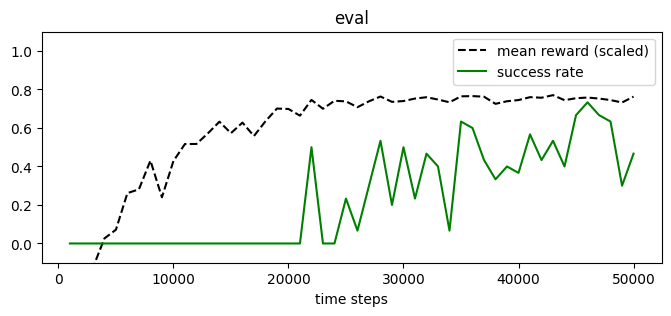

In [22]:
from navground.learning.utils.sb3 import plot_eval_logs

plot_eval_logs(log, reward_low=-400, reward_high=0, success=True, figsize=(8, 3))

In [23]:
from stable_baselines3.common.evaluation import evaluate_policy

evaluate_policy(model.policy, test_venv, n_eval_episodes=100)

(-94.33800991, 17.15960643500521)

In [24]:
from navground.learning.evaluation.video import display_episode_video
from navground.learning.scenarios.pad import render_kwargs

display_episode_video(eval_env, policy=policy, factor=4, seed=1, **kwargs)

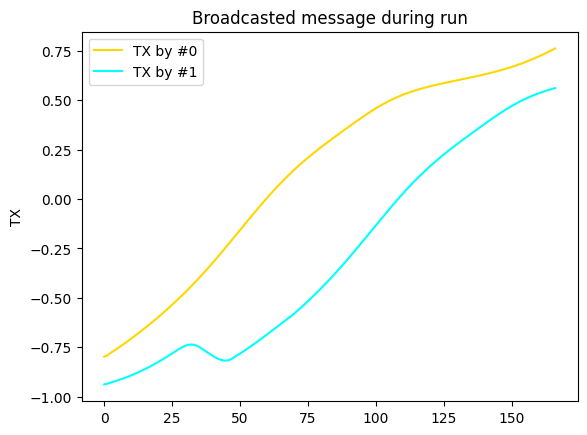

In [25]:
from navground.learning.evaluation.experiment import make_experiment_with_env
from navground.learning.probes.comm import CommProbe
from matplotlib import pyplot as plt
import numpy as np

exp = make_experiment_with_env(eval_env, policy=policy)
exp.add_record_probe('tx', CommProbe)
run = exp.run_once(seed=1)
for i, color in enumerate(('gold', 'cyan')):
    plt.plot(np.asarray(run.records['tx'])[:, i, 0], color=color, label=f"TX by #{i}")
plt.legend()
plt.ylabel("TX")
plt.title("Broadcasted message during run");

We have a look at the trained policy.

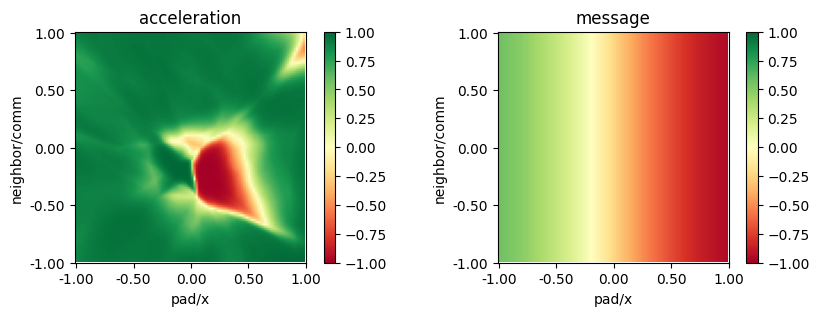

In [26]:
from navground.learning.utils.plot import plot_policy

plot_policy(policy, 
            variable={'pad/x': (-1, 1), 'neighbor/comm': (-1, 1)},
            fix={'ego_velocity': 0.1},
            actions={0: 'acceleration', 1: 'message'}, 
            width=5, height=3)

We see how the agents learnt to encode their position in the communication, which they then use to avoid entering the pad together.

In [27]:
from navground.learning.onnx import export

best_model = SAC.load(f'{log}/best_model')
best_policy = DistributedCommPolicy(eval_env.observation_space(0),
                                    eval_env.action_space(0),  best_model.policy)
export(best_policy, f'{log}/policy.onnx')